# Application Example for EvoBandits

Setup

In [31]:
import json
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import PowerNorm
import numpy as np
from tqdm import tqdm

In [30]:
from application_example import (
    genetic_algorithm,
    TSP_CITIES,
    TSP_OPT_COST,
    TSP_OPT_TOUR
)

In [170]:
plt.style.use("default")

mpl.rcParams["font.family"] = "serif"
mpl.rcParams["font.serif"] = [
    "Computer Modern Roman",
    "Times New Roman",
    "Times",
    "DejaVu Serif",
]
mpl.rcParams["font.size"] = 16


## 1. Application Example

A genetic algorithm, which solves a fixed instance of the Traveling Salesman Problem (TSP), is applied as example for a stochastic optimization problem. 

The known optimal tour of this 100-city TSP can be used as reference for the evaluation of optimization results.

In [27]:
print(f"Cost of the best tour:\t{TSP_OPT_COST}")

Cost of the best tour:	7.28473


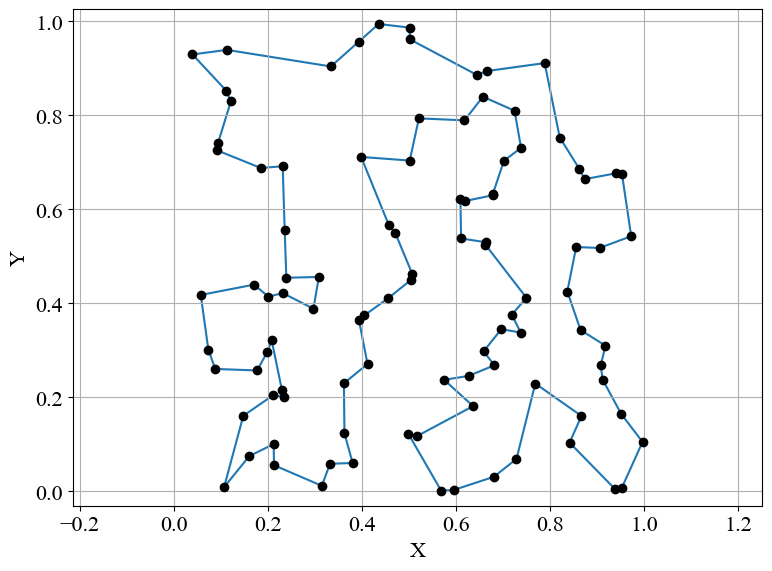

In [171]:
fig, ax = plt.subplots(figsize=(8, 6))

tour_path = TSP_CITIES[TSP_OPT_TOUR]
tour_path = np.vstack([tour_path, tour_path[0]])
ax.plot(tour_path[:, 0], tour_path[:, 1], "-", c="C0", zorder=1)
ax.scatter(TSP_CITIES[:, 0], TSP_CITIES[:, 1], c="black", zorder=2)

ax.grid(True)
ax.axis("equal")
ax.set_xlabel("X")
ax.set_ylabel("Y")

plt.tight_layout()
plt.savefig(Path("_plots/01_tsp_opt.pdf"))
plt.show()

## 2. Optimization with EvoBandits

### 2.1 Optimization

The configuration of the genetic algorithm will be optimized using EvoBandits.

Parameter Space for the optimization:

In [6]:
from evobandits import IntParam, CategoricalParam, FloatParam

params = {
    "pop_size": IntParam(low=50, high=250, size=1),
    "generations": CategoricalParam(choices=[100, 200, 300, 400, 500]),
    "elite_split": FloatParam(low=0.0, high=0.2, n_steps=20), 
    "tournament_split": FloatParam(low=0.0, high=0.1, n_steps=10),
    "mutation_rate": FloatParam(low=0.0, high=1.0, n_steps=100), 
    "crossover_rate": FloatParam(low=0.0, high=1.0, n_steps=100), 
}

Algorithm Configuration:

In [7]:
from evobandits import GMAB

gmab_instance = GMAB(mutation_span=0.2)

The optimization requires wrapping the genetic algorithm, so that only the objective value (best_cost) is returned as single objective for the optimizer:

In [8]:
from evobandits import Study

def objective(seed: int, **params: dict):
    """Seeded, single-objective function to simulate the GA."""
    best_cost, _ = genetic_algorithm(seed=seed, **params)
    return best_cost

study = Study(algorithm=gmab_instance, seed=42)
study.optimize(objective, params, n_trials=1000, n_best=1000, n_runs=3)

In [9]:
json.dump(study.results, open(Path("_data/01_evobandits_demo_results.json"), 'w'))

### 2.2 Study Output

Display raw results (example):

In [10]:
study.results[0]

{'value': 7.676092401868324,
 'value_std_dev': 0.21233815611830814,
 'n_evaluations': 7,
 'params': {'pop_size': 229,
  'generations': 500,
  'elite_split': 0.19,
  'tournament_split': 0.1,
  'mutation_rate': 0.96,
  'crossover_rate': 0.0},
 'n_best': 1,
 'run_id': 0}

Aggregate Results:

In [14]:
print(f"Configuration with best result:\t{study.best_params}")
print(f"Best cost found with evobandits:\t{study.best_value}")

Configuration with best result:	{'pop_size': 250, 'generations': 500, 'elite_split': 0.02, 'tournament_split': 0.09, 'mutation_rate': 0.87, 'crossover_rate': 0.06}
Best cost found with evobandits:	7.501620509934057


### 2.3 Evaluate the result

Re-evaluate the best configuration, and compare to the best reported value from optimization.

In [13]:
results = []
rng = np.random.default_rng(seed=42)

for _ in tqdm(range(1000), desc="Re-evaluate best configuration:"):
    seed = rng.integers(0, 2**32 - 1, dtype=int)
    best_cost, _ = genetic_algorithm(seed=seed, **study.best_params)
    results.append(best_cost)

json.dump(results, open(Path("_data/02_evobandits_demo_evaluation.json"), 'w'))

Re-evaluate best configuration:: 100%|██████████| 1000/1000 [52:51<00:00,  3.17s/it] 


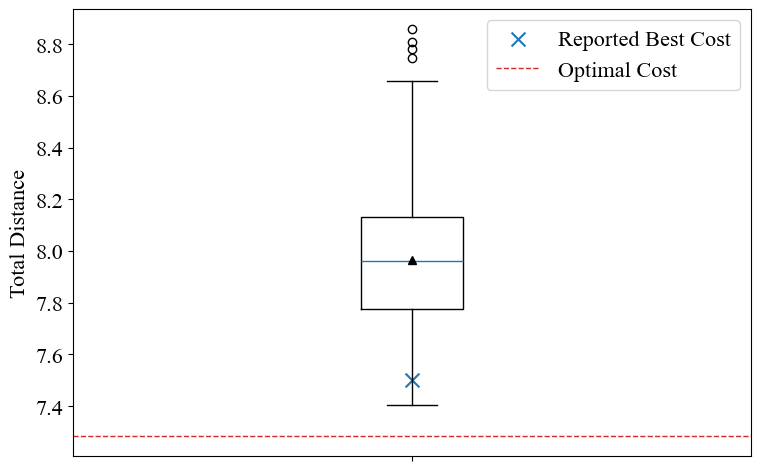

In [179]:
plt.figure(figsize=(8, 5))

plt.boxplot(results, tick_labels=[""], showmeans=True, meanprops={"markerfacecolor":"black", "markeredgecolor":"black"}, medianprops={"color": "C0"})
plt.scatter(1, study.best_value, marker='x', s=100, color="C0", label="Reported Best Cost")
plt.axhline(TSP_OPT_COST, linestyle='--', linewidth=1, color="C3", label="Optimal Cost")

plt.ylabel("Total Distance")

plt.legend()
plt.tight_layout()
plt.savefig(Path("_plots/02_evobandits_demo_results.pdf"))
plt.show()

## 3. Analysis

### 3.1 Size of the Search Space

In [55]:
total_combinations = 1
for name, par in params.items():
    lower_bound, upper_bound = par.bounds[0]
    cnt_different_values = upper_bound - lower_bound
    total_combinations *= cnt_different_values
    print(f"Distint values for {name}:\t{cnt_different_values}")
print(f"Total Number of Combinations:\t{total_combinations    }")

Distint values for pop_size:	200
Distint values for generations:	4
Distint values for elite_split:	20
Distint values for tournament_split:	10
Distint values for mutation_rate:	100
Distint values for crossover_rate:	100
Total Number of Combinations:	1600000000


### 3.2 Best configuration: Spread of Results

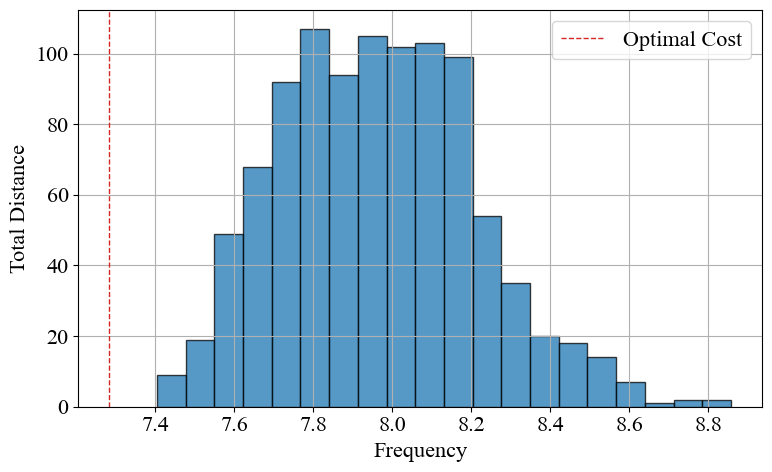

In [178]:
plt.figure(figsize=(8, 5))
plt.grid()

plt.hist(results, bins=20, alpha=0.75, edgecolor="black")
plt.axvline(TSP_OPT_COST, linestyle='--', linewidth=1, color="C3", label="Optimal Cost")

plt.ylabel("Total Distance")
plt.xlabel("Frequency")
plt.legend()

plt.tight_layout()
plt.savefig(Path("_plots/03_ga_results_spread.pdf"))
plt.show()

### 3.3 Best configuration: Stability of Mean vs. Number of Simulations

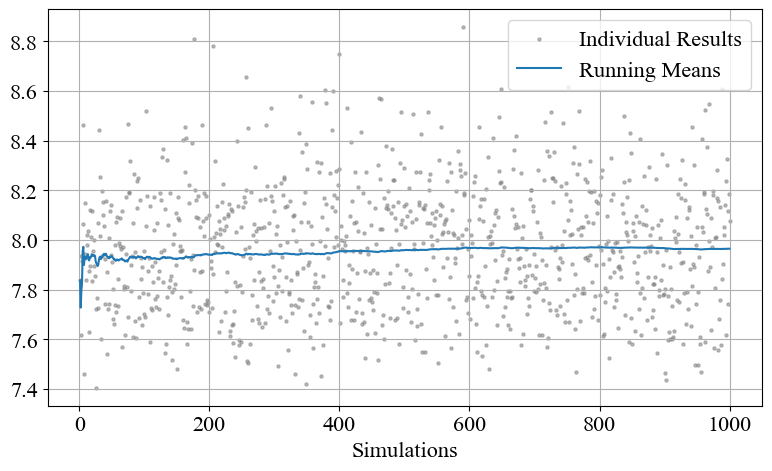

In [181]:
plt.figure(figsize=(8, 5))
plt.grid()

sim_idx = np.arange(1, len(results) + 1)
plt.scatter(sim_idx, results, s=5, alpha=0.5, color="C7", label="Individual Results")

running_means = np.cumsum(results) / sim_idx
plt.plot(sim_idx, running_means, color="C0", label="Running Means")

plt.xlabel("Total Distance")
plt.xlabel("Simulations")
plt.legend()

plt.tight_layout()
plt.savefig(Path("_plots/03_ga_results_means.pdf"))
plt.show()

### 3.4: Relationships of parameters accross all sampled configurations

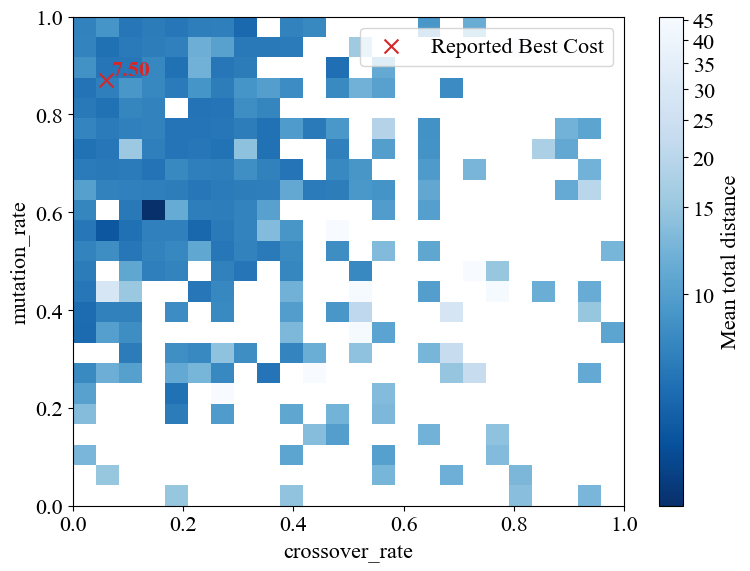

In [182]:
def plot_heatmap(x_feature, y_feature, bins, cmap_gamma=1, show_best=True, results=study.results):
    # Extract data
    x = np.array([r["params"][x_feature] for r in results])
    y = np.array([r["params"][y_feature] for r in results])
    heat = np.array([r["value"] for r in results])

    # Define grid
    x_bins = np.linspace(min(x), max(x), bins[0])
    y_bins = np.linspace(min(y), max(y), bins[1])

    # Bin data into 2D histogram: average "value" per bin
    heatmap = np.full((len(x_bins) - 1, len(y_bins) - 1), np.nan)
    counts = np.zeros_like(heatmap)

    # Bin manually to compute mean per bin
    digitized_x = np.digitize(x, x_bins) - 1
    digitized_y = np.digitize(y, y_bins) - 1

    for xi, yi, val in zip(digitized_x, digitized_y, heat):
        if 0 <= xi < heatmap.shape[0] and 0 <= yi < heatmap.shape[1]:
            if np.isnan(heatmap[xi, yi]):
                heatmap[xi, yi] = val
                counts[xi, yi] = 1
            else:
                heatmap[xi, yi] += val
                counts[xi, yi] += 1

    # Avoid divide-by-zero
    heatmap = heatmap / np.where(counts == 0, 1, counts)
    heatmap[counts == 0] = np.nan  # reset truly empty bins

    # Plot (incl. scaling of colormap)
    fig, ax = plt.subplots(figsize=(8, 6))
    norm = PowerNorm(gamma=cmap_gamma)
    mesh = ax.pcolormesh(x_bins, y_bins, heatmap.T, cmap='Blues_r', norm=norm)
    fig.colorbar(mesh, ax=ax, label='Mean total distance')

    if show_best:
        best_x, best_y = study.best_params[x_feature], study.best_params[y_feature]
        best_value = study.best_value

        ax.scatter(best_x, best_y, color="C3", marker="x", s=100, label="Reported Best Cost")
        ax.text(best_x + 0.01, best_y + 0.01, f"{best_value:.2f}", color="C3", weight="bold")
        plt.legend()

    ax.set_xlim((min(x), max(x)))
    ax.set_ylim((min(y), max(y)))
    ax.set_xlabel(x_feature)
    ax.set_ylabel(y_feature)
    plt.tight_layout()

    fig_name = f"04_heatmap_{x_feature}_{y_feature}.pdf"
    plt.savefig(Path(f"_plots/{fig_name}"))
    plt.show()


plot_heatmap("crossover_rate", "mutation_rate", bins=(25, 25), cmap_gamma=0.3)

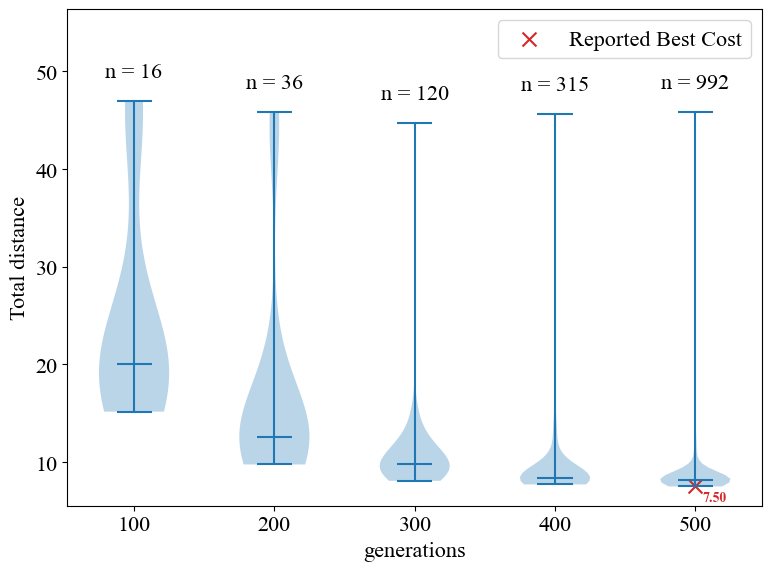

In [185]:
def plot_violin(feature, tick_labels=None, show_best=True, results=study.results):
    # Extract data
    features = np.array([r["params"][feature] for r in study.results])
    values = np.array([r["value"] for r in study.results])

    # Group data
    unique_features = np.sort(np.unique(features))
    grouped_values = [values[features == feature_value] for feature_value in unique_features]

    # Plot
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.violinplot(grouped_values, positions=range(1, len(unique_features) + 1), showextrema=True, showmedians=True)
    ax.set_xticks(range(1, len(unique_features) + 1))

    if not tick_labels:
        tick_labels = [f"{val:.2f}" for val in unique_features]
    ax.set_xticklabels(tick_labels)

    # Counts above violins
    for i, g in enumerate(grouped_values, 1):
        ax.text(i, max(g) + 0.05*(max(values)-min(values)), f"n = {len(g)}",
                ha='center', va='bottom')
        
    if show_best:
        best_feature = study.best_params[feature]
        best_value = study.best_value

        pos = list(unique_features).index(best_feature) + 1  # +1 because violinplot positions start at 1
        ax.scatter(pos, best_value, color='C3', marker='x', s=100, label='Reported Best Cost')
        ax.text(pos + 0.05, best_value - 1.5, f"{best_value:.2f}", color='C3', fontsize=10, weight='bold')

    ax.set_xlabel(feature)
    ax.set_ylabel("Total distance")
    ax.set_ylim(top=max(values) * 1.2)

    plt.legend()
    plt.tight_layout()
    fig_name = f"05_violinplot_{feature}.pdf"
    plt.savefig(Path(f"_plots/{fig_name}"))
    plt.show()

plot_violin("generations", tick_labels=["100", "200", "300", "400", "500"])